📋 Available cash flow columns:
['Free Cash Flow', 'Repurchase Of Capital Stock', 'Repayment Of Debt', 'Issuance Of Debt', 'Issuance Of Capital Stock', 'Capital Expenditure', 'Interest Paid Supplemental Data', 'Income Tax Paid Supplemental Data', 'End Cash Position', 'Beginning Cash Position', 'Changes In Cash', 'Financing Cash Flow', 'Cash Flow From Continuing Financing Activities', 'Net Other Financing Charges', 'Cash Dividends Paid', 'Common Stock Dividend Paid', 'Net Common Stock Issuance', 'Common Stock Payments', 'Common Stock Issuance', 'Net Issuance Payments Of Debt', 'Net Short Term Debt Issuance', 'Net Long Term Debt Issuance', 'Long Term Debt Payments', 'Long Term Debt Issuance', 'Investing Cash Flow', 'Cash Flow From Continuing Investing Activities', 'Net Other Investing Changes', 'Net Investment Purchase And Sale', 'Sale Of Investment', 'Purchase Of Investment', 'Net Business Purchase And Sale', 'Purchase Of Business', 'Net PPE Purchase And Sale', 'Purchase Of PPE', 'Operat

2021-09-30    190.009
2022-09-30    211.553
2023-09-30    188.093
2024-09-30    213.203
dtype: object


🎯 DCF Valuation Summary
Latest FCF: 213.20 B USD
Projected WACC: 9.00%, Terminal Growth: 2.50%
Enterprise Value: 4247.66 B USD
Net Debt: 98.19 B USD
Equity Value: 4149.47 B USD
Fair Value per Share: 277.82 USD
Current Price: 213.55 USD
📈 The stock appears UNDERVALUED.


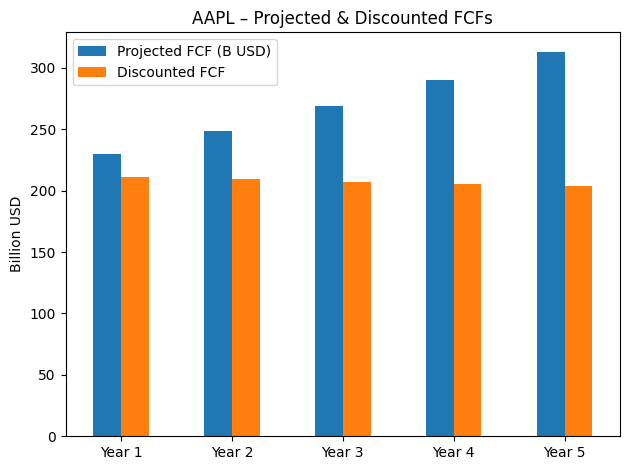

In [5]:
# Step 1: Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Set ticker and load data
ticker = "AAPL"
stock = yf.Ticker(ticker)
info = stock.info
cashflow = stock.cashflow.T  # transpose for time orientation

# Step 3–4: Dynamically identify and compute Free Cash Flow (Operating CF - CapEx)
available_columns = list(cashflow.columns)
print("📋 Available cash flow columns:")
print(available_columns)

# Try to match the correct column names dynamically
op_col = next((col for col in available_columns if "Operating" in col), None)
capex_col = next((col for col in available_columns if "Capital Expenditures" in col or "Capital" in col), None)

if op_col is None or capex_col is None:
    print("❌ Could not find necessary components to compute FCF.")
    raise SystemExit("🔁 Try another ticker with valid cash flow data.")

# Compute Free Cash Flow
op_cash = cashflow[op_col]
capex = cashflow[capex_col]
fcf = (op_cash - capex).dropna() / 1e9  # Convert to billions
fcf.index = fcf.index.astype(str)
fcf = fcf.sort_index(ascending=True)

# Display historical FCF
print(f"\n📊 Historical Free Cash Flows for {ticker} (in B USD):")
display(fcf)

# Project FCF over 5 years
latest_fcf = fcf.iloc[-1]
growth_rate = 0.08
projection_years = 5
fcf_projections = [latest_fcf * (1 + growth_rate) ** i for i in range(1, projection_years + 1)]
projection_index = [f"Year {i}" for i in range(1, projection_years + 1)]
fcf_df = pd.DataFrame(data=fcf_projections, index=projection_index, columns=["Projected FCF (B USD)"])

# Step 5: Compute terminal value and discounting
terminal_growth = 0.025  # 2.5% perpetual growth
wacc = 0.09  # 9% discount rate

terminal_value = fcf_projections[-1] * (1 + terminal_growth) / (wacc - terminal_growth)
terminal_value_discounted = terminal_value / ((1 + wacc) ** projection_years)

# Discount FCFs
discounted_fcfs = [fcf / ((1 + wacc) ** (i+1)) for i, fcf in enumerate(fcf_projections)]
total_pv_fcfs = sum(discounted_fcfs)

# Step 6: Compute Enterprise Value
enterprise_value = total_pv_fcfs + terminal_value_discounted

# Step 7: Adjust for net debt (usually negative for cash-rich firms)
net_debt = info.get("totalDebt", 0) - info.get("cash", 0)
equity_value = enterprise_value - net_debt / 1e9  # Convert debt to billions

# Step 8: Fair value per share
shares_outstanding = info.get("sharesOutstanding", 0)
fair_value_per_share = (equity_value * 1e9) / shares_outstanding  # Convert back to USD

# Step 9: Compare to market price
current_price = info.get("currentPrice")

# Step 10: Output results
print("\n🎯 DCF Valuation Summary")
print(f"Latest FCF: {latest_fcf:.2f} B USD")
print(f"Projected WACC: {wacc:.2%}, Terminal Growth: {terminal_growth:.2%}")
print(f"Enterprise Value: {enterprise_value:.2f} B USD")
print(f"Net Debt: {net_debt/1e9:.2f} B USD")
print(f"Equity Value: {equity_value:.2f} B USD")
print(f"Fair Value per Share: {fair_value_per_share:.2f} USD")
print(f"Current Price: {current_price:.2f} USD")

if fair_value_per_share > current_price:
    print("📈 The stock appears UNDERVALUED.")
elif fair_value_per_share < current_price:
    print("📉 The stock appears OVERVALUED.")
else:
    print("⚖️ The stock appears FAIRLY VALUED.")

# Step 11: Visualize FCF Projections
fcf_df["Discounted FCF"] = discounted_fcfs
fcf_df.plot(kind="bar")
plt.title(f"{ticker} – Projected & Discounted FCFs")
plt.ylabel("Billion USD")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

✅ PDF report saved as: AAPL_DCF_Valuation_2025-07-06.pdf


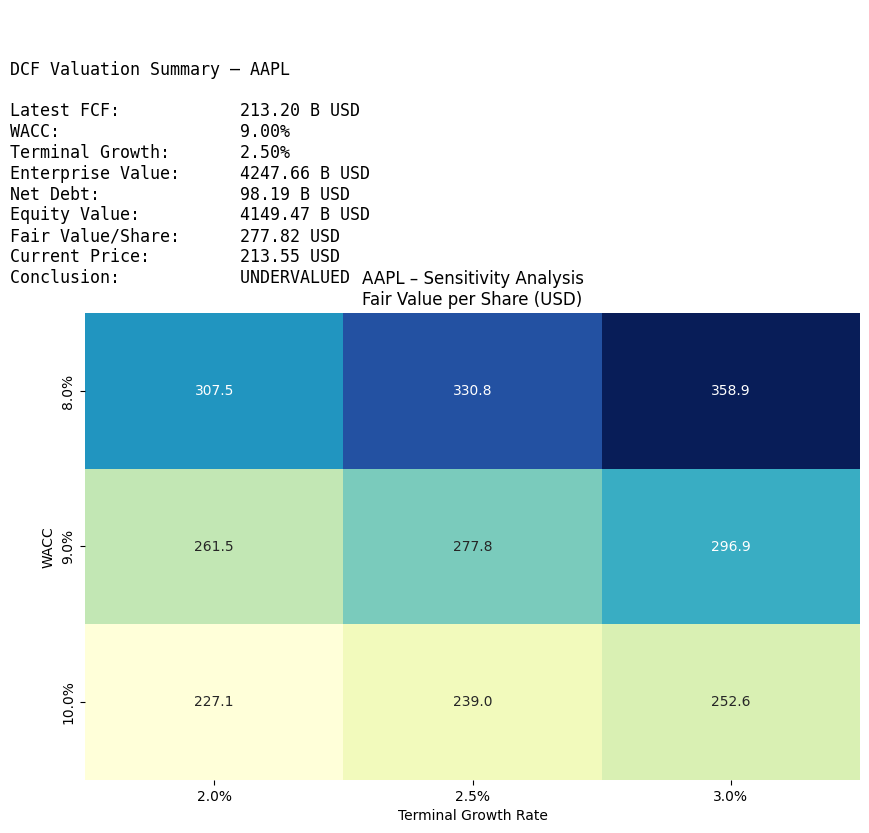

In [7]:
import matplotlib.backends.backend_pdf

# Step 13: Generate and save a professional PDF with valuation summary + heatmap
from datetime import datetime

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))
plt.axis("off")

# Create text block (left side)
summary_text = f"""
DCF Valuation Summary – {ticker}

Latest FCF:            {latest_fcf:.2f} B USD
WACC:                  {wacc:.2%}
Terminal Growth:       {terminal_growth:.2%}
Enterprise Value:      {enterprise_value:.2f} B USD
Net Debt:              {net_debt/1e9:.2f} B USD
Equity Value:          {equity_value:.2f} B USD
Fair Value/Share:      {fair_value_per_share:.2f} USD
Current Price:         {current_price:.2f} USD
Conclusion:            {"UNDERVALUED" if fair_value_per_share > current_price else "OVERVALUED"}
"""

fig.text(0.05, 0.85, summary_text, fontsize=12, family='monospace', verticalalignment='top')

# Add heatmap
from matplotlib import gridspec
import seaborn as sns

gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])
ax1 = fig.add_subplot(gs[1])
sns.heatmap(sensitivity_table.astype(float), annot=True, fmt=".1f", cmap="YlGnBu", ax=ax1,
            cbar=False)
ax1.set_title(f"{ticker} – Sensitivity Analysis\nFair Value per Share (USD)", fontsize=12)
ax1.set_xlabel("Terminal Growth Rate")
ax1.set_ylabel("WACC")

# Save PDF
today = datetime.today().strftime("%Y-%m-%d")
filename = f"{ticker}_DCF_Valuation_{today}.pdf"
fig.savefig(filename, bbox_inches='tight')

print(f"✅ PDF report saved as: {filename}")

In [9]:
!pip install openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]


In [10]:
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Font
import os

wb = Workbook()
ws_summary = wb.active
ws_summary.title = "DCF Summary"

# Section 1: Résumé DCF
ws_summary.append(["DCF Valuation Summary"])
ws_summary.append(["Company", ticker])
ws_summary.append(["Latest FCF (B USD)", round(latest_fcf, 2)])
ws_summary.append(["WACC", f"{wacc:.2%}"])
ws_summary.append(["Terminal Growth", f"{terminal_growth:.2%}"])
ws_summary.append(["Enterprise Value (B USD)", round(enterprise_value, 2)])
ws_summary.append(["Net Debt (B USD)", round(net_debt / 1e9, 2)])
ws_summary.append(["Equity Value (B USD)", round(equity_value, 2)])
ws_summary.append(["Fair Value per Share (USD)", round(fair_value_per_share, 2)])
ws_summary.append(["Current Market Price (USD)", round(current_price, 2)])
ws_summary.append(["Conclusion", "UNDERVALUED" if fair_value_per_share > current_price else "OVERVALUED"])

# Apply bold to titles
for cell in ws_summary["A"]:
    cell.font = Font(bold=True)

# Section 2: FCF Table
ws_fcf = wb.create_sheet("FCF Projection")
ws_fcf.append(["Year", "Projected FCF (B USD)", "Discounted FCF (B USD)"])
for year, fcf_proj, fcf_disc in zip(fcf_df.index, fcf_df["Projected FCF (B USD)"], fcf_df["Discounted FCF"]):
    ws_fcf.append([year, round(fcf_proj, 2), round(fcf_disc, 2)])

# Section 3: Sensitivity Table
ws_sens = wb.create_sheet("Sensitivity Table")
ws_sens.append(["WACC ↓ / Growth →"] + list(sensitivity_table.columns))
for idx, row in sensitivity_table.iterrows():
    ws_sens.append([idx] + list(row.values))

# Save file
excel_filename = f"{ticker}_DCF_Report_{today}.xlsx"
wb.save(excel_filename)
print(f"✅ Excel file saved as: {excel_filename}")

✅ Excel file saved as: AAPL_DCF_Report_2025-07-06.xlsx
